In [7]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.io as sp
from scipy.io import loadmat
from sklearn.svm import LinearSVR
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
import os
import glob
from pathlib import Path

In [11]:
def networks(md, X_train, y_train):
    
    if md != 'random_forest':
        X_train, y_train = np.array(X_train), np.array(y_train)
      #  X_test = np.array(test_data)
        
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
      #  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
    if md == 'lstm':
        model = Sequential()
        model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units = 64, return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(units = 64))
        model.add(Dropout(0.2))
        model.add(Dense(units = 1))
    
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss = 'mean_squared_error', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs = 10, batch_size = 128)
        
    elif md == 'simple_rnn':
        model = Sequential()
        model.add(SimpleRNN(128, return_sequences=True, input_shape = (X_train.shape[1], 1)))
        model.add(SimpleRNN(128, return_sequences = True))
        model.add(SimpleRNN(128, return_sequences = True))
        model.add(Dense(units=1)) # The time step of the output
        
        model.compile(optimizer='rmsprop', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=20, batch_size=200, verbose=0)
    
    elif md == 'gru':
        # The GRU architecture
        model = Sequential()
        # First GRU layer with Dropout regularisation
        model.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
        model.add(Dropout(0.2))
        # Second GRU layer
        model.add(GRU(units=32, return_sequences=True, activation='tanh'))
        model.add(Dropout(0.2))

        # Third GRU layer
        model.add(GRU(units=32, return_sequences=True, activation='tanh'))
        model.add(Dropout(0.2))
        # Fourth GRU layer
        model.add(GRU(units=32, activation='tanh'))
        model.add(Dropout(0.2))
        # The output layer
        model.add(Dense(units=1))
        # Compiling the RNN
        model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.6, nesterov=False),loss='mean_squared_error')
        # Fitting to the training set
        model.fit(X_train,y_train,epochs=50,batch_size=128, verbose=0)
        
    elif md == 'random_forest':
        model = RandomForestRegressor(n_estimators = 100, random_state=42)
        model.fit(X_train, y_train.values.ravel())
        
    elif md == 'svr':
        nsamples, nx, ny = X_train.shape
        X_train_2d = X_train.reshape((nsamples,nx*ny))
        y_train_2d = np.array(y_train)
        y_train_1d = y_train_2d.flatten()
        
        model = LinearSVR(verbose=0, C=1, epsilon=0, fit_intercept=True, intercept_scaling=1.0, max_iter=1000,random_state=None, tol=0.0001)
        model.fit(X_train_2d, y_train_1d)
        
    else:
        print('No Such Model')
    
    return model

In [12]:
def calculations(file_path, model_name):
    original_mat = pd.DataFrame(loadmat(file_path+'original.mat')['y'])
    hidden_mat = pd.DataFrame(loadmat(file_path+'hiddenData.mat')['KK'])
    stego_mat = pd.DataFrame(loadmat(file_path+'stegoAudio.mat')['W'])
    stego_recon = pd.DataFrame(loadmat(file_path+'reconstructedAudio.mat')['recon'])
    
    nan_index = stego_mat[0].index[stego_mat[0].apply(np.isnan)]
    stego_mat.iloc[nan_index] = 0

    original_drop_mat = original_mat.copy()
    original_drop_mat.iloc[nan_index] = 0

    hidden_drop_mat = hidden_mat.copy()
    hidden_drop_mat.iloc[nan_index] = 0

    test_data = hidden_mat.copy()
    test_data = test_data.iloc[nan_index]
    
    X_train = hidden_drop_mat;
    #y_train = original_drop_mat;
    y_train = stego_mat;
    
    #Model Calls
    model = networks(model_name, X_train, y_train)
    
    X_test = test_data
    plt.plot(X_test)
    X_test = np.array(test_data)
   # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_recon_audio = model.predict(X_test)
    
    #final_mat = original_drop_mat.copy()
    final_mat = stego_mat.copy()
    for ind, val in enumerate(predicted_recon_audio):
        final_mat.iloc[nan_index[ind]] = val
    
    reconstructed_audio = {"reconL": final_mat.values, "Fs": float(22050)}
    sp.savemat(file_path+model_name+"longer_reconstructed_audio.mat", reconstructed_audio)
    
    values_view = reconstructed_audio.values()
    value_iterator = iter(values_view)
    first_value = next(value_iterator)
    recon_mat = pd.DataFrame(first_value)
    frames = pd.concat([original_mat, recon_mat, stego_mat, stego_recon], axis=1)
    
    frames.columns = ['original', model_name, 'stego_audio', 'stego_recon']
    
    print(frames.corr())
    
    plt.figure(figsize=(20,10))
    plt.plot(original_mat, color = 'blue', label = 'Original Audio')
    plt.plot(recon_mat, color = 'red', label = 'Reconstructed Audio')
    plt.title('Audio Reconstruction')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

Single
1min
4 seconds
             original       svr  stego_audio  stego_recon
original     1.000000  0.841326     0.323446     0.818234
svr          0.841326  1.000000     0.440229     0.983718
stego_audio  0.323446  0.440229     1.000000     0.594428
stego_recon  0.818234  0.983718     0.594428     1.000000


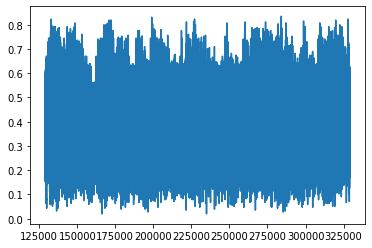

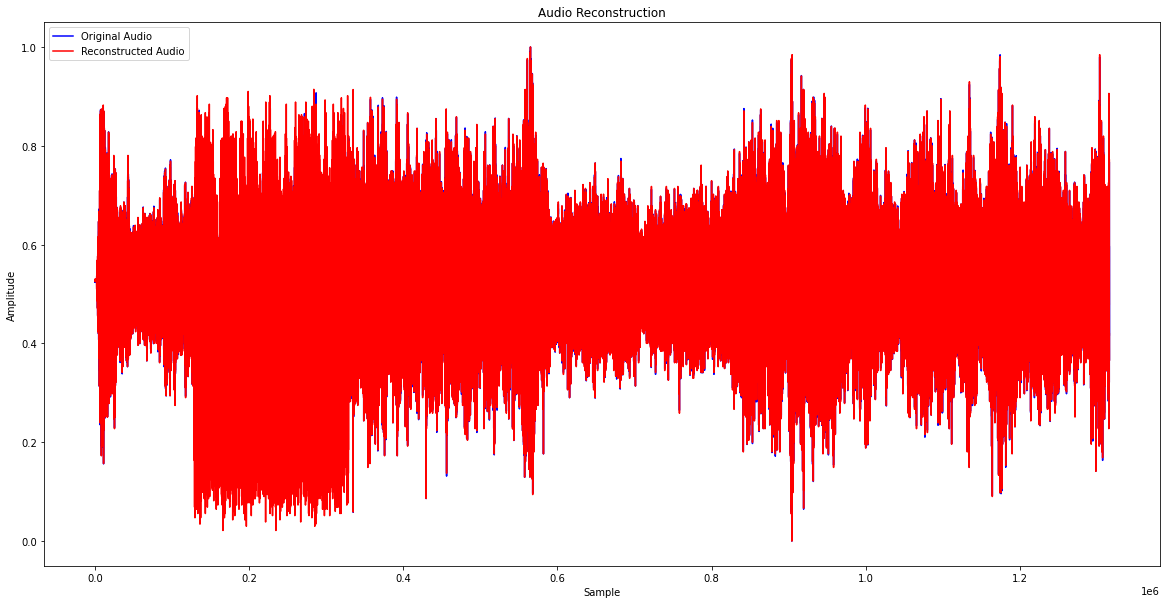

In [13]:
model_name = 'svr'

grand_directory_contents = os.listdir('./')
for grand_item in grand_directory_contents:
     if (os.path.isdir(grand_item)) and ('ipynb' not in grand_item):
        print(grand_item);
        
        directory_contents = os.listdir('./'+grand_item)
        for item in directory_contents:
            if (os.path.isdir('./'+grand_item+'/'+item)) and ('min' in item):
                print(item);
                
                sub_directory_contents = os.listdir('./'+grand_item+'/'+item)
                for sub_dir_item in sub_directory_contents:
                    print(sub_dir_item+' seconds');
                    
                    file_path = './'+grand_item+'/'+item+'/'+sub_dir_item+'/'
                    calculations(file_path, model_name);
        
        